In [1]:
%reload_ext autoreload
%autoreload 2


In [2]:
from atomphys.data import nist
from pprint import pprint

from atomphys import Atom
from atomphys.state import State
from atomphys.transition import Transition

from pint import get_application_registry

import itertools

_ureg = get_application_registry()


In [3]:
atom = Atom('my Ca+')

# def load_from_nist(atom, name, refresh_cache=False):
name = 'Ca+'
refresh_cache = False
    
states_data, transitions_data = nist.load_from_nist(name, refresh_cache)


In [4]:
s0 = State(**states_data[0])
s0

State(3p6.4s 2S1/2 0 Ry)

In [5]:
s0.Gamma

C:\Users\carmelo\eth\projects\atomphys_tiqi\atomphys\state.py:118: UserWarning: State not attached to an Atom: no transitions available
  warnings.warn("State not attached to an Atom: no transitions available")


0 <Unit('megahertz')>

In [6]:
from atomphys.util import set_default_units

energy_cutoff = 'inf'  # '1800 planck_constant THz'
energy_cutoff = set_default_units(energy_cutoff, 'Ry', atom._ureg)
energy_cutoff

inf <Unit('rydberg')>

In [7]:

all_states = [
    State(configuration=d['configuration'], term=d['term'], energy=d['energy'])
    for d in states_data
    if atom._ureg(d['energy']) < energy_cutoff
]

len(all_states)


72

In [8]:

atom.add_states(all_states)
# a.add_states(states)


In [9]:
s1 = atom.states[1]
s1

State(3p6.3d 2D3/2 0.1244 Ry)

In [10]:
s1.Gamma

0 <Unit('megahertz')>

In [11]:
atom.transitions_to(s1)

[]

In [12]:
transitions_data[0]

{'A': '2.42e+07 s^-1',
 'state_i': {'energy': '0.1243897 Ry', 'term': '2D3/2'},
 'state_f': {'energy': '0.832333 Ry', 'term': '2F*5/2'}}

In [13]:
ms = [s for s in atom.states if s.match('2F*5/2')]
ms

[State(3p6.4f 2F*5/2 0.6202 Ry),
 State(3p6.5f 2F*5/2 0.7111 Ry),
 State(3p6.6f 2F*5/2 0.7605 Ry),
 State(3p6.7f 2F*5/2 0.7903 Ry),
 State(3p6.8f 2F*5/2 0.8096 Ry),
 State(3p6.9f 2F*5/2 0.8229 Ry),
 State(3p6.10f 2F*5/2 0.8323 Ry)]

In [14]:
ee = _ureg('0.832333 Ry')
min(ms, key=lambda state: abs(state.energy - ee))


State(3p6.10f 2F*5/2 0.8323 Ry)

In [15]:
transitions = []
for d in transitions_data:
    ti = d['state_i']['term']
    tf = d['state_f']['term']
    si = atom._match_term_and_energy(ti, d['state_i']['energy'])
    sf = atom._match_term_and_energy(tf, d['state_f']['energy'])
    print(d)
    print(si, sf)
    print()
    # sf = atom.get_state_by_energy(d['state_f']['energy'])
    # if si.match(ti) and sf.match(tf):
    #     tr = Transition(si, sf, d['A'])
    #     transitions.append(tr)
    # else:
        # print('not found')
# transitions



{'A': '2.42e+07 s^-1', 'state_i': {'energy': '0.1243897 Ry', 'term': '2D3/2'}, 'state_f': {'energy': '0.832333 Ry', 'term': '2F*5/2'}}
State(3p6.3d 2D3/2 0.1244 Ry) State(3p6.10f 2F*5/2 0.8323 Ry)

{'A': '1.72e+06 s^-1', 'state_i': {'energy': '0.1249427 Ry', 'term': '2D5/2'}, 'state_f': {'energy': '0.832333 Ry', 'term': '2F*5/2'}}
State(3p6.3d 2D5/2 0.1249 Ry) State(3p6.10f 2F*5/2 0.8323 Ry)

{'A': '2.58e+07 s^-1', 'state_i': {'energy': '0.1249427 Ry', 'term': '2D5/2'}, 'state_f': {'energy': '0.832333 Ry', 'term': '2F*7/2'}}
State(3p6.3d 2D5/2 0.1249 Ry) State(3p6.10f 2F*7/2 0.8323 Ry)

{'A': '3.28e+07 s^-1', 'state_i': {'energy': '0.1243897 Ry', 'term': '2D3/2'}, 'state_f': {'energy': '0.822874 Ry', 'term': '2F*5/2'}}
State(3p6.3d 2D3/2 0.1244 Ry) State(3p6.9f 2F*5/2 0.8229 Ry)

{'A': '2.34e+06 s^-1', 'state_i': {'energy': '0.1249427 Ry', 'term': '2D5/2'}, 'state_f': {'energy': '0.822874 Ry', 'term': '2F*5/2'}}
State(3p6.3d 2D5/2 0.1249 Ry) State(3p6.9f 2F*5/2 0.8229 Ry)

{'A': '3.52e

In [16]:
atom.add_transitions(transitions)

In [17]:
s1.Gamma

0 <Unit('megahertz')>

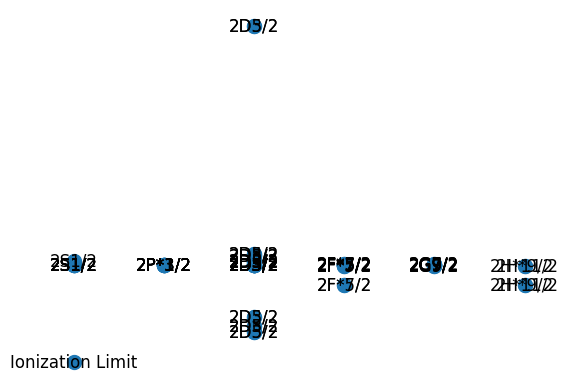

In [18]:
from atomphys.plot import plot_atom

plot_atom(atom, spread_threshold=1e-2)

In [76]:
import matplotlib.pyplot as plt
from atomphys import plot as aplot

In [88]:
ca_full = Atom.from_nist('Ca')


Loading atom Ca
Added 783 states
Dropping 2 unmatched transitions
Added 135 transitions


In [89]:
ca_full

Atom(Ca 783 states 135 transitions)

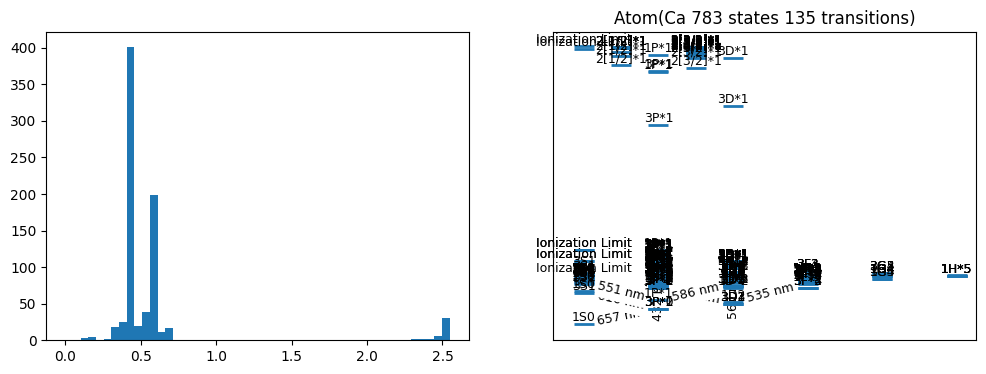

In [90]:
fig, (axh, ax) = plt.subplots(1, 2, figsize=(12, 4))

aplot.plot_energy_histogram(ca_full, ax=axh)
aplot.plot_atom(ca_full, ax=ax)

In [91]:
ca_full._match_term('Ionization Limit')

[State(Ca II (4s 2S<1/2>) Ionization Limit 0.4493 Ry),
 State(Ca II (3d 2D<3/2>) Ionization Limit 0.5737 Ry),
 State(Ca II (3d 2D<5/2>) Ionization Limit 0.5743 Ry),
 State(Ca II (4p 2P*<1/2>) Ionization Limit 0.6789 Ry),
 State(Ca II (4p 2P*<3/2>) Ionization Limit 0.6809 Ry),
 State(Ca II (3p5.4s2 2P*<3/2>) Ionization Limit 2.522 Ry),
 State(Ca II (3p5.4s2 2P*<1/2>) Ionization Limit 2.547 Ry)]

In [128]:
ca = Atom.from_nist('Ca', energy_cutoff=0.4)


Loading atom Ca
Added 52 states
Dropping 2 unmatched transitions
Added 135 transitions


In [1]:
fig, (axh, ax) = plt.subplots(1, 2, figsize=(12, 4))

aplot.plot_energy_histogram(ca, ax=axh)
aplot.plot_atom(ca, ax=ax)

fig, (axh, ax) = plt.subplots(1, 2, figsize=(12, 4))

# remove ground state
ca2 = ca.copy()
s0 = ca.states[0]
ca2.remove_state(s0)

aplot.plot_energy_histogram(ca2, ax=axh)
aplot.plot_atom(ca2, ax=ax)


NameError: name 'plt' is not defined

Removed 8 states without transitions


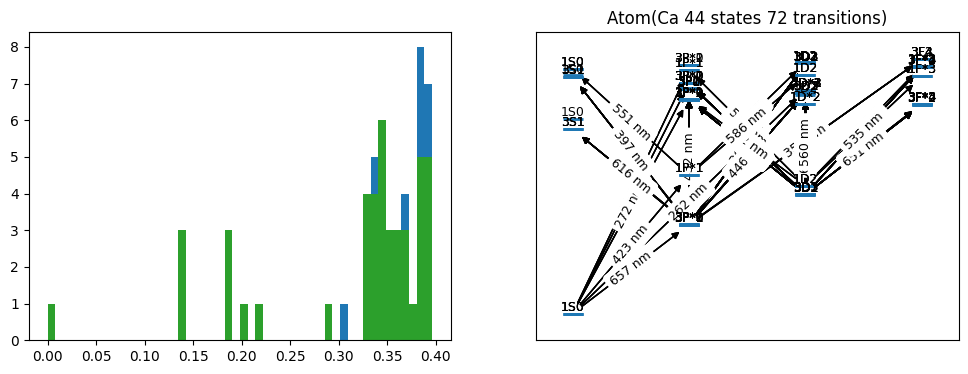

In [84]:
ca2 = ca.remove_isolated(copy=True)

aplot.plot_energy_histogram(ca2, ax=axh)
aplot.plot_atom(ca2, ax=ax)
fig

In [23]:
max(ca.states, key=lambda s: s.energy)

State(3p6.3d.4p 3D*3 0.3486 Ry)

In [24]:
import networkx as nx

def remove_isolated(atom, keep_ionization_limit=True):
    g = atom._graph
    if keep_ionization_limit:
        isolated = [n for n in nx.isolates(g) if not n.quantum_numbers.ionization_limit]
    else:
        isolated = list(nx.isolates(g))
    g.remove_nodes_from(isolated)
    print(f"Removed {len(isolated)} states without transitions")



Removed 0 states without transitions


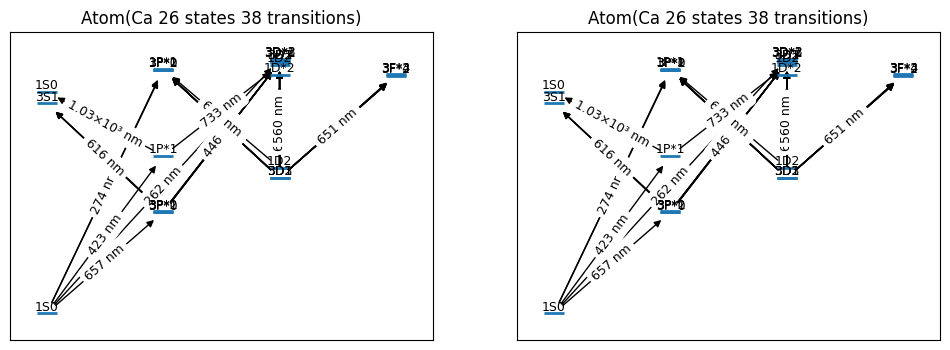

In [71]:
from copy import deepcopy
import matplotlib.pyplot as plt

ca2 = deepcopy(ca)
remove_isolated(ca2, keep_ionization_limit=True)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
plot_atom(ca, ax=ax)
plot_atom(ca2, ax=ax2)

In [29]:
ca2

Atom(Ca 26 states 38 transitions)

In [30]:
p1 = ca.get_state_by_name('1P*1')
ca.transitions_to(p1)
p1.Gamma

34.69577759403318 <Unit('megahertz')>

In [31]:
cai = Atom.from_nist('ca+', energy_cutoff=0.5)

21 unmatched transitions


In [33]:
from math import pi
p2 = cai.get_state_by_energy(_ureg('397 nm').to('Ry'))
p2.Gamma

23.968734429639436 <Unit('megahertz')>

(0.0, 30.0)

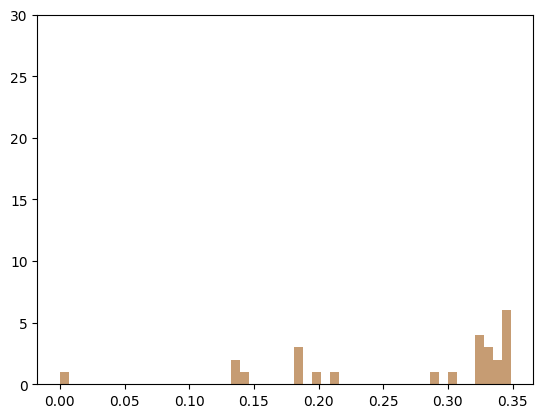

In [34]:
import matplotlib.pyplot as plt
_ = plt.hist([s.energy.m for s in ca.states], 50, alpha=0.5)
_ = plt.hist([s.energy.m for s in ca2.states], 50, alpha=0.5)
plt.ylim(0, 30)


In [35]:
from atomphys import Atom
from atomphys.data.cache import set_cache_dir

set_cache_dir('../.atomphys')

In [47]:
yb = Atom.from_nist('Yb+')
len(yb.states)


235

In [48]:
yb

Atom(Yb+ 235 states 9 transitions)

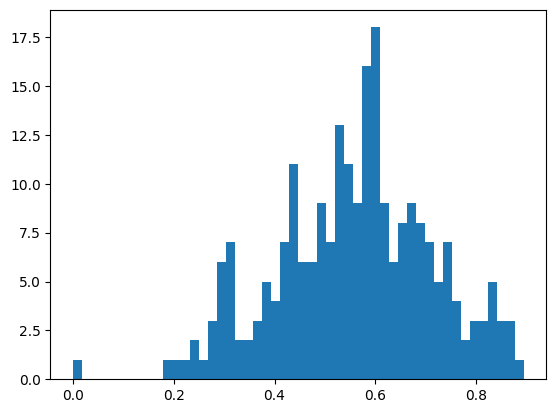

In [49]:
from atomphys import plot as aplot

_ = aplot.plot_energy_histogram(yb, unit='Ry')

Removed 223 states without transitions


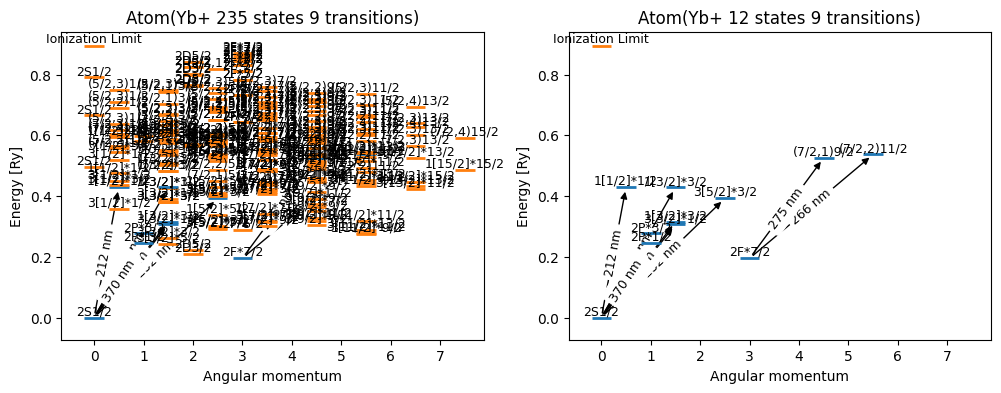

In [119]:
from atomphys.plot import plot_atom

yb2 = deepcopy(yb)
remove_isolated(yb2, keep_ionization_limit=True)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
plot_atom(yb, ax=ax)
plot_atom(yb2, ax=ax2)


In [113]:
yb

Atom(Yb+ 235 states 9 transitions)

Loading atom Yb+
Added 35 states
Dropping 2 unmatched transitions
Added 8 transitions


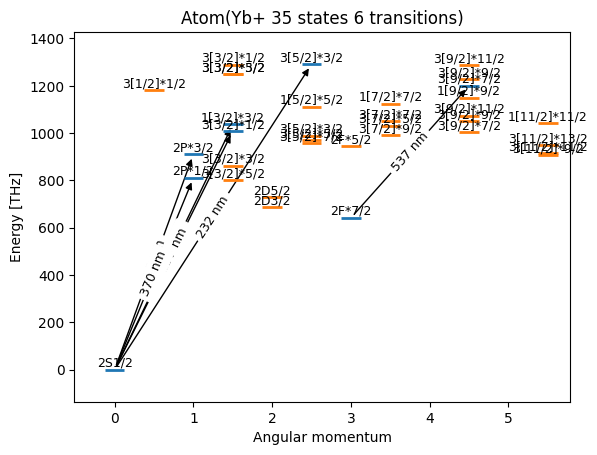

In [122]:
yb3 = Atom.from_nist('Yb+', energy_cutoff=0.4)
plot_atom(yb3, energy_units='THz')
# yb3.isolated_states

Loading atom Ca+
Added 38 states
Added 99 transitions
Removed 7 states without transitions


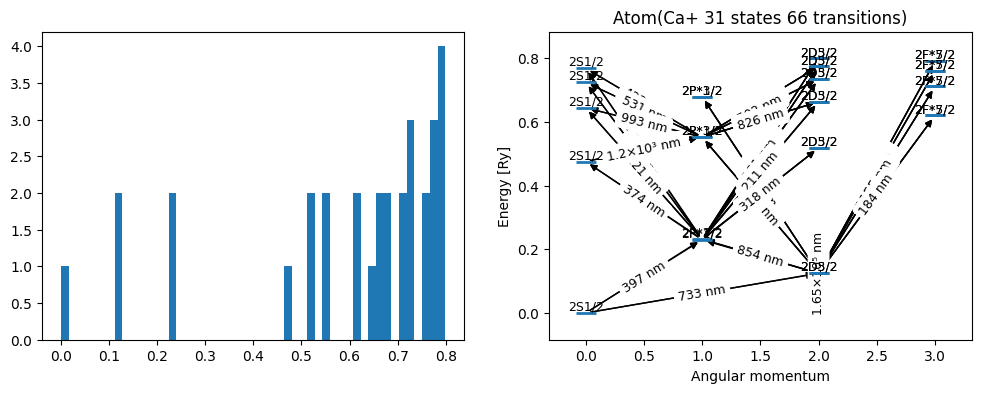

In [105]:
fig, (axh, ax) = plt.subplots(1, 2, figsize=(12, 4))

# ca = Atom.from_nist('Ca+', energy_cutoff="inf")
ca = Atom.from_nist('Ca+', energy_cutoff=0.8, remove_isolated=True)

aplot.plot_energy_histogram(ca, ax=axh)
aplot.plot_atom(ca, ax=ax)


Loading atom Ba+
Added 162 states
Added 112 transitions
Removed 109 states without transitions


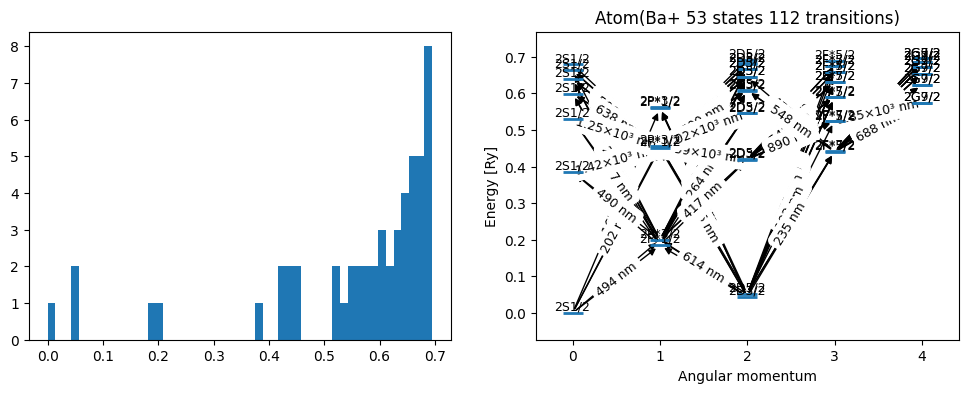

In [110]:
fig, (axh, ax) = plt.subplots(1, 2, figsize=(12, 4))

ba = Atom.from_nist('Ba+', energy_cutoff="inf", remove_isolated=True)
# ba = Atom.from_nist('Ba+', energy_cutoff=0.8, remove_isolated=True)

aplot.plot_energy_histogram(ba, ax=axh)
aplot.plot_atom(ba, ax=ax)


In [111]:
ba.isolated_states

[]

In [40]:
from atomphys.data.cache import get_cache_dir, clear_cache_dir

get_cache_dir()

WindowsPath('C:/Users/carmelo/eth/projects/atomphys_tiqi/.atomphys')

In [41]:
clear_cache_dir()